In [1]:
import sys
sys.path.append("../../")

import os

import uuid
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely import wkt

from povertymapping import settings, nightlights
from povertymapping.iso3 import get_iso3_code
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.feature_engineering import generate_features
import getpass
import pickle

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap

/home/jace/workspace/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/jace/workspace/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext autoreload
%autoreload 2

## Single-country model for predicting wealth index (Timor Leste)
This notebook trains the model which will be rolled out to all populated areas for the given country. The output model is a Random Forest regressor trained on scaled labels (DHS Wealth Index) and features (area statistics for OSM, Ookla, and nighttime lights).

## Set up Data Access
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [3]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

2023-03-14 12:35:56.157 | INFO     | povertymapping.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-03-14 12:35:56.167 | INFO     | povertymapping.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Load Target Country From DHS data

In [4]:
# Set country-specific variables
country_osm = "east-timor"
ookla_year = 2019
nightlights_year = 2016
country_code = get_iso3_code(country_osm, code='alpha-2').lower()
dhs_household_dta_path = settings.DATA_DIR/"dhs/tl/TLHR71DT/TLHR71FL.DTA"
dhs_geographic_shp_path = settings.DATA_DIR/"dhs/tl/TLGE71FL/TLGE71FL.shp"
rollout_date = '-'.join(os.getcwd().split('/')[-2].split('-')[:3])

In [ ]:
dhs_gdf = generate_dhs_cluster_level_data(
    dhs_household_dta_path, 
    dhs_geographic_shp_path, 
    col_rename_config=country_code,
    convert_geoms_to_bbox=True,
    bbox_size_km=2.4
).reset_index(drop=True)
dhs_gdf.explore()

In [9]:
# Inspect the generated data
dhs_gdf.head(3)

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,F21,F22,F23,geometry
0,1,32166.600000,TL201600000001,TL,2016.0,TT,NULL,NULL,NULL,NULL,...,R,-8.712016,125.567381,9999.0,1005.0,WGS84,None,None,None,"POLYGON ((125.55646 -8.70122, 125.57830 -8.701..."
1,2,-34063.923077,TL201600000002,TL,2016.0,TT,NULL,NULL,NULL,NULL,...,R,-8.730226,125.590219,9999.0,1342.0,WGS84,None,None,None,"POLYGON ((125.57930 -8.71943, 125.60114 -8.719..."
2,3,39230.590909,TL201600000003,TL,2016.0,TT,NULL,NULL,NULL,NULL,...,R,-8.741340,125.556399,9999.0,1060.0,WGS84,None,None,None,"POLYGON ((125.54548 -8.73055, 125.56732 -8.730..."


## Generate Labels and Base Features

We normalized each model feature by country to correct country-specific feature quirks, as well as the wealth index.

This method has been done in a [similar study](https://doi.org/10.1073/pnas.2113658119) using DHS as training data and was also documented [here](https://www.dhsprogram.com/pubs/pdf/MR9/MR9.pdf).

Models recover how relative values of input data (relative to other locations in that country) correlate with relative values of wealth (also relative to other locations in that country).

The current best model setup involves (1) normalizing all features per country using `StandardScaler` and (2) scaling the wealth index per country using `StandardScaler`

If this is your first time running this notebook for this specific area, expect a long runtime for the following cell as it will download and cache the required datasets. It will then process the relevant features for each area specified. On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 

In [10]:
# Indicate name of column from dhs data that will be used as the label for training
label_col = 'Wealth Index'

In [11]:
%%time
scaler = StandardScaler
country_data = dhs_gdf.copy()

# Create labels dataframe by scaling the specified label_col (ex. Wealth Index)
country_data[['label']] = scaler().fit_transform(country_data[[label_col]])
labels = country_data[['label']]

# Create features dataframe using generate_features module
features = generate_features(country_data, country_osm, ookla_year, nightlights_year, scaled_only=True, sklearn_scaler=scaler,features_only=True)

2023-03-12 13:50:08.539 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for east-timor at /home/jace/.geowrangler/osm/east-timor? True
2023-03-12 13:50:08.540 | DEBUG    | povertymapping.osm:load_pois:149 - OSM POIs for east-timor being loaded from /home/jace/.geowrangler/osm/east-timor/gis_osm_pois_free_1.shp
2023-03-12 13:50:10.210 | INFO     | povertymapping.osm:download_osm_country_data:187 - OSM Data: Cached data available for east-timor at /home/jace/.geowrangler/osm/east-timor? True
2023-03-12 13:50:10.211 | DEBUG    | povertymapping.osm:load_roads:168 - OSM Roads for east-timor being loaded from /home/jace/.geowrangler/osm/east-timor/gis_osm_roads_free_1.shp
2023-03-12 13:50:11.142 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: []
2023-03-12 13:50:11.145 | INFO     | povertymapping.ookla:load_type_year_data:83 - Cached data available at /home/jace/.geowrangler/ookla/processed/206a0323fa0e80f8233

CPU times: user 4.14 s, sys: 984 ms, total: 5.12 s
Wall time: 5.48 s


## Inspect the training data

### Labels

array([[<AxesSubplot: title={'center': 'label'}>]], dtype=object)

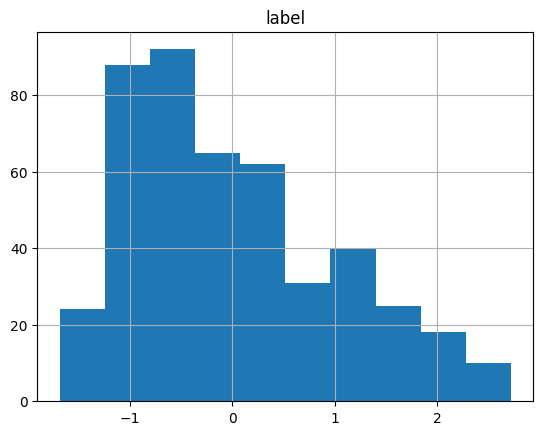

In [12]:
labels.hist()

### Features

The features can be subdivided by the source dataset.

#### OSM
- `<poi type>_count`: number of points of interest (POI) of a specified type in that area
    - ex. atm_count: number of atms in cluster
    - poi_count: number of all POIs *of all types* in cluster 
- `<poi_type>_nearest`: distance of nearest POI of the specified type
    - ex. atm_nearest: distance of nearest ATM from that cluster
- OSM POI types included: `atm`, `bank`, `bus_stations`, `cafe`, `charging_station`, `courthouse`, `dentist` (clinic), `fast_food`, `fire_station`, `food_court`, `fuel` (gas station), `hospital`, `library`, `marketplace`, `pharmacy`, `police`, `post_box`, `post_office`, `restaurant`, `social_facility`, `supermarket`, `townhall`, `road`

#### Ookla 
The network metrics features follow the following name convention:

> `<type>_<year>_<yearly aggregate>_<network variable>_<cluster aggregate>`

- type: kind of network connection measured
    - fixed: connection from fixed sources (landline, fiber, etc.)
    - mobile: connection from mobile devices
- year: Year of source data
- yearly aggregate: How data was aggregated into yearly data
    - Note: Ookla provides data per quarter, so a yearly mean takes the average across 4 quarters
    - For this model, we only aggregate by yearly mean
- network variable: network characteristic described
    - avg_d_kbps: average download speed in kbps
    - avg_u_kbps: average upload speed in kbps
    - avg_lat_ms: average latency in ms
    - num_devices: number of devices measured
- cluster aggregate: how the data was aggregated per cluster aggregate
    - Types: min, mean, max, median, std.
        - For this model: only mean is used 
    - This is calculated using area zonal stats, which weighs the average by the intersection of the Ookla tile with the cluster geometry.
    
    
Ex. `fixed_2019_mean_avg_d_kbps_median` takes the cluster median of 2019 yearly average download speed.


#### Nightlights (VIIRS)
All nightlights features are taken as the zonal aggregate of the raster data per cluster

- ex. `avg_rad_mean`: cluster mean of the average radiance 
- aggregations used: min, mean, max, median

In [13]:
features.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 455 entries, 0 to 454
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   poi_count_scaled                          455 non-null    float64
 1   atm_count_scaled                          455 non-null    float64
 2   atm_nearest_scaled                        455 non-null    float64
 3   bank_count_scaled                         455 non-null    float64
 4   bank_nearest_scaled                       455 non-null    float64
 5   bus_station_count_scaled                  455 non-null    float64
 6   bus_station_nearest_scaled                455 non-null    float64
 7   cafe_count_scaled                         455 non-null    float64
 8   cafe_nearest_scaled                       455 non-null    float64
 9   charging_station_count_scaled             455 non-null    float64
 10  charging_station_nearest_scale

## Model Training

In [14]:
# Set parameters
cv_num_splits = 5
cv_num_repeats = 5
train_test_seed = 42
test_size = 0.2

### Create train/test cross-validation indices

In [15]:
# Cross validation
print(f"Performing {cv_num_splits}-fold CV...")
cv = RepeatedKFold(n_splits=cv_num_splits, n_repeats=cv_num_repeats, random_state=train_test_seed)

print(cv.split(features))


Performing 5-fold CV...
<generator object _RepeatedSplits.split at 0x7f62923ec120>


### Instantiate model
For now, we will train a simple random forest model

In [16]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=train_test_seed, verbose=0)
model

RandomForestRegressor(random_state=42)

### Evaluate model training using cross-validation
We evalute the model's generalizability when training over different train/test splits

Ideally for R^2
- We want a high mean: This means that we achieve a high model performance over the different train/test splits
- We want a low standard deviation (std): This means that the model performance is stable over multiple training repetitions

In [17]:
R_cv = cross_val_score(model, features.values, labels.values.ravel(), cv=cv)
print("Cross validation scores are: ", R_cv)
cv_mean = round(np.array(R_cv).mean(), 2)
cv_std = round(np.array(R_cv).std(), 2)
print(f"Cross validation R^2 mean: {cv_mean}")
print(f"Cross validation R^2 std: {cv_std}")

Cross validation scores are:  [0.521971   0.71898809 0.60881035 0.6155512  0.58167542 0.57577221
 0.61226752 0.56309205 0.61979645 0.58306217 0.6563282  0.55676737
 0.66921322 0.53745665 0.32769142 0.55851165 0.72957847 0.55079573
 0.62967437 0.54378733 0.55473236 0.52470165 0.65351152 0.55534308
 0.61215454]
Cross validation R^2 mean: 0.59
Cross validation R^2 std: 0.08


### Train the final model

For training the final model, we train on all the available data.

In [18]:
model.fit(features.values, labels.values.ravel())

RandomForestRegressor(random_state=42)

## Model Evaluation

### SHAP Feature Importance

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

In [20]:
shap_values

array([[ 2.33585105e-03,  1.21011130e-04, -5.44752043e-03, ...,
        -7.27118671e-02,  2.83804278e-02,  2.34772983e-02],
       [-3.39490708e-04,  1.12963026e-04, -8.65631850e-03, ...,
        -1.19804498e-01, -1.00992328e-01, -4.37399572e-02],
       [ 1.27627596e-03,  2.22551879e-04, -6.02958009e-03, ...,
        -8.09733419e-02,  4.84437897e-02,  2.60216496e-02],
       ...,
       [-2.37436935e-02,  3.43668054e-04, -3.61529307e-03, ...,
         1.40138516e-01,  1.75053031e-01,  8.06585493e-03],
       [ 8.02441744e-04,  1.22405542e-04, -5.84437868e-03, ...,
        -7.95983077e-02, -5.41841759e-02,  1.93222930e-02],
       [-8.02061108e-03,  1.54916778e-04, -1.08133754e-02, ...,
        -1.24723933e-01, -9.66318861e-02, -1.11650915e-01]])

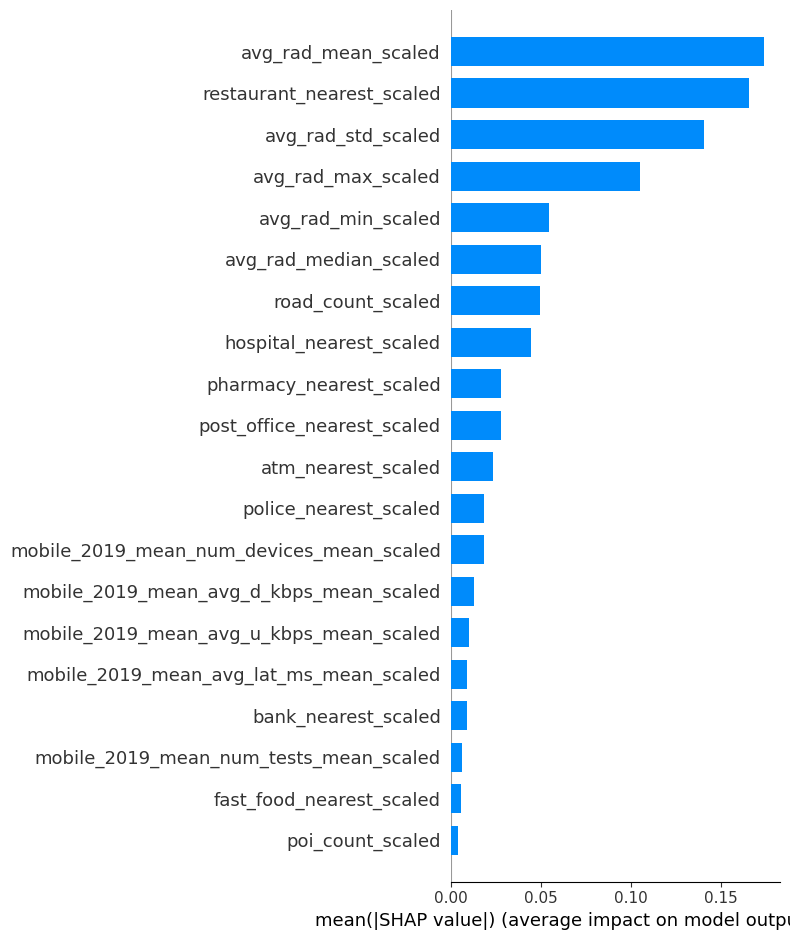

In [21]:
shap.summary_plot(shap_values, features, feature_names=features.columns, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


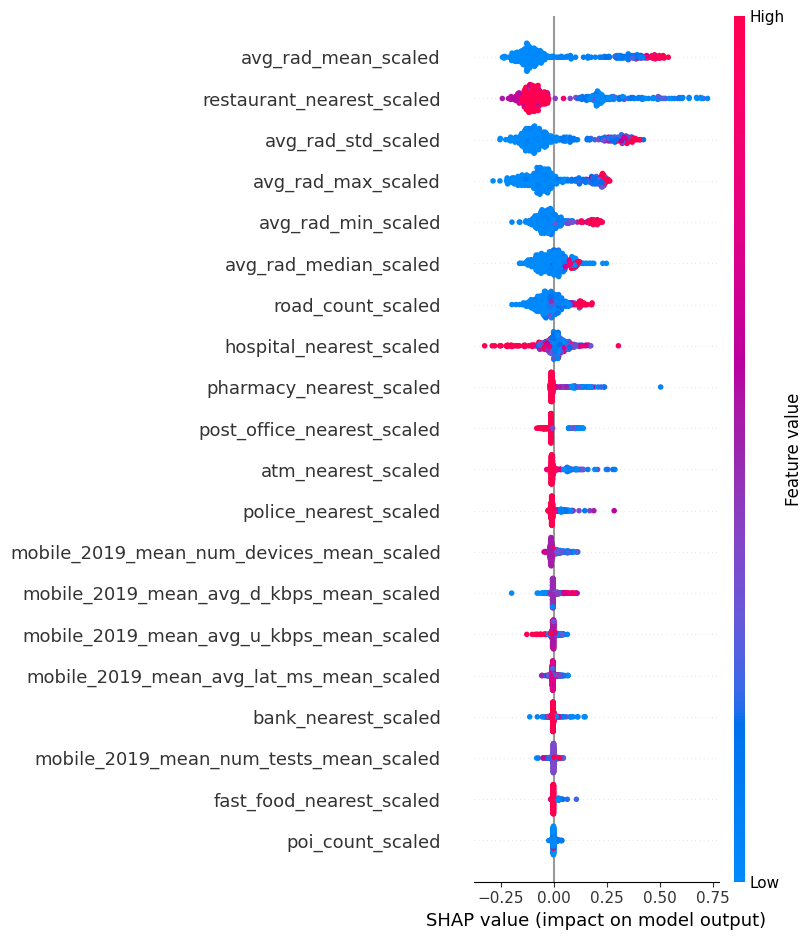

In [22]:
shap.summary_plot(shap_values, features.values, feature_names=features.columns)

## Save Model

In [23]:
model_save_path = f'./{rollout_date}-{country_code}-single-country-model.pkl'
with open(model_save_path, "wb") as file:
    pickle.dump(model, file)